In [33]:
import csv

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.device('/gpu:0')
RANDOM_SEED = 42

# Specify each path

In [34]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [35]:
NUM_CLASSES = 5

# Dataset reading

In [36]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [37]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [39]:
X_dataset_check = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(0, (21 * 2) + 1)))
b = pd.DataFrame(X_dataset_check)
print(b)

        0    1    2         3         4         5         6         7   \
0      0.0  0.0  0.0 -0.122378 -0.108392 -0.227273 -0.307692 -0.171329   
1      0.0  0.0  0.0 -0.125436 -0.097561 -0.233449 -0.292683 -0.177700   
2      0.0  0.0  0.0 -0.122378 -0.101399 -0.227273 -0.293706 -0.174825   
3      0.0  0.0  0.0 -0.125874 -0.090909 -0.230769 -0.283217 -0.178322   
4      0.0  0.0  0.0 -0.125874 -0.087413 -0.237762 -0.283217 -0.181818   
...    ...  ...  ...       ...       ...       ...       ...       ...   
15175  4.0  0.0  0.0  0.056000 -0.304000 -0.008000 -0.616000 -0.120000   
15176  4.0  0.0  0.0  0.047619 -0.293651 -0.007937 -0.611111 -0.134921   
15177  4.0  0.0  0.0  0.023810 -0.301587 -0.055556 -0.642857 -0.222222   
15178  4.0  0.0  0.0  0.030534 -0.297710 -0.068702 -0.641221 -0.244275   
15179  4.0  0.0  0.0  0.000000 -0.300000 -0.130769 -0.646154 -0.338462   

             8         9   ...        33        34        35        36  \
0     -0.468531 -0.027972  ... -0.003

In [40]:
b.groupby(0).size()


0
0.0    3000
1.0    3166
2.0    2837
3.0    2931
4.0    3246
dtype: int64

# Model building

In [41]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [42]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) # automatically save your model
# verbose : gọi lại thông báo mỗi khi thông báo
# save_weights_only: lưu lại cả mô hình lẫn thông số mô hình nếu False

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# dừng quá trình đào tạo nếu hiệu suất mô hình ko đc cải thiện

In [44]:
# Model compilation
model.compile(
    optimizer='adam', # hàm tối ưu
    loss='sparse_categorical_crossentropy', # hàm mất mát
    metrics=['accuracy'] # thuước  đo đánh giá
)

# Model training

In [45]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
62/89 [===================>..........] - ETA: 0s - loss: 1.5571 - accuracy: 0.2816
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
89/89 [==============================] - 1s 6ms/step - loss: 1.5266 - accuracy: 0.3038 - val_loss: 1.2954 - val_accuracy: 0.6395
Epoch 2/1000
80/89 [=========================>....] - ETA: 0s - loss: 1.3426 - accuracy: 0.4350
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
89/89 [==============================] - 0s 5ms/step - loss: 1.3339 - accuracy: 0.4384 - val_loss: 1.0257 - val_accuracy: 0.7233
Epoch 3/1000
65/89 [====================>.........] - ETA: 0s - loss: 1.2045 - accuracy: 0.5035
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
89/89 [==============================] - 0s 3ms/step - loss: 1.1918 - accuracy: 0.5094 - val_loss: 0.8551 - val_accuracy: 0.8079
Epoch 4/1000
65/89 [====================>.........] - ETA: 0s - loss: 1.0989 - accuracy: 0.5422
E

In [46]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

30/30 [==============================] - 0s 1ms/step - loss: 0.3324 - accuracy: 0.9381


In [47]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [48]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 69ms/step
[1.4748171e-03 4.1047713e-01 1.5927158e-02 1.6785218e-06 5.7211924e-01]
4


# Confusion matrix

119/119 [==============================] - 0s 822us/step


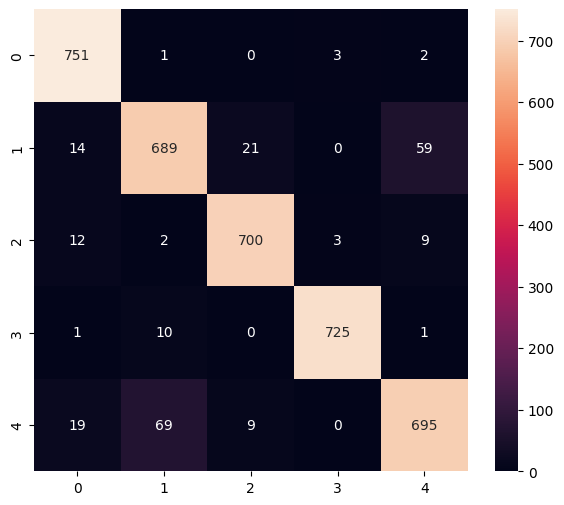

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       757
           1       0.89      0.88      0.89       783
           2       0.96      0.96      0.96       726
           3       0.99      0.98      0.99       737
           4       0.91      0.88      0.89       792

    accuracy                           0.94      3795
   macro avg       0.94      0.94      0.94      3795
weighted avg       0.94      0.94      0.94      3795



In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [50]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [51]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpagizgl5a\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpagizgl5a\assets


6616

# Inference test

In [52]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [53]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [54]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [55]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1 ms


In [56]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.4748158e-03 4.1047710e-01 1.5927162e-02 1.6785204e-06 5.7211930e-01]
4
